# Learning Representations by Recirculation
## Geoffrey Hinton & James McClelland

Presented at Neural Information Processing Systems, 1988, pages 358-366.

This Jupyter Notebook aims to reproduce the type of neural network outlined in this paper and the results of a simulation. The key interesting point of this paper is that the network weights are trained not via backpropagation, but instead by comparing the difference to an input vector after it is recirculated through the network.

The network is comprised of an input ("visible") layer with 4 neurons, fully connected to a hidden layer of 2 neurons, fully connected to the "visible" layer in a closed loop. The network aims to reconstruct the input vector from the hidden layer. The "reconstruction error" is measured:

$$
E = \frac{1}{2} \sum \left[y_i(2) - y_i(0)\right]^2
$$

where $y_i(2)$ is the activation value of neuron $i$ in the visible layer at time step 2 and $y_i(0)$ is the initial value of the neuron, equal to the input vector.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%config IPCompleter.use_jedi = False

In [4]:
# Activation function
def sigmoid(X):
    return 1/(1+np.exp(-X))

## Constructing and training the network

In a production setting, the code below would be packaged into Python classes with methods used for initialization, training, weight updates, and outputing the results, but I kept it simple for a first version. There are probably numerous code optimizations that could be applied that would make it run faster, but at the cost of readability.

In [44]:
# Network parameters
n_visible = 4
n_hidden = 2
bias = 1

# Training parameters
n_epochs = 100
eps = 20
lam = 0.75

# Initialize the random weight matrices. i: visible neurons. j: hidden neurons
W_ji = np.random.random((n_hidden, n_visible + bias))-0.5  # shape: 2x5
W_ij = np.random.random((n_visible, n_hidden + bias))-0.5  # shape: 4x3

# List A will keep track of the visible vectors
A = []

# A batch of 4 input vectors
A_0 = np.array([[1,0,0,0],
                [0,1,0,0],
                [0,0,1,0],
                [0,0,0,1]])
A.append(A_0)

# A list to track the batch reconstruction error
Error = []

# Train the network
for epoch in range(1, n_epochs):
    # Temporary list to track the reconstructed input vectors
    AA = []
    
    # Add up the deltas to the weight matrices
    dw_ji = np.zeros(np.shape(W_ji))
    dw_ij = np.zeros(np.shape(W_ij))
    
    # Loop over the vectors in the input batch and evolve them
    for vec in A[0]:
        # TIME 0: capture initial state
        I0 = vec # shape: 4x1
        
        # TIME 0 to 1: visible to hidden
        y_i_0 = np.insert(vec, 0, 1) # add bias
        y_j_1 = sigmoid(np.dot(W_ji, y_i_0)) # (2x5).(5x1) = 2x1
        J1 = y_j_1 # shape: 2x1
        
        # TIME 1 to 2: hidden to visible
        y_j_1 = np.insert(y_j_1, 0, 1) # add bias
        y_i_2 = sigmoid(np.dot(W_ij, y_j_1)) # (4x3).(3x1) = 4x1
        I2z = y_i_2 # Save a copy with zero regression
        y_i_2 = lam * I0 + (1 - lam) * y_i_2 # regression, shape: 4x1
        I2 = y_i_2
        
        # TIME 2 to 3: visible to hidden (second pass)
        y_i_2 = np.insert(y_i_2, 0, 1) # add bias
        y_j_3 = sigmoid(np.dot(W_ji, y_i_2)) # ()
        y_j_3 = lam * J1 + (1 - lam) * y_j_3 # regression, shape: 2x1
        J3 = y_j_3
        
        # Collect vectors
        AA.append(I2z)
        
        # Calculate weight update for W_ij
        ## TODO: Vectorize these if possible
        for i in range(n_visible):
            for j in range(n_hidden + bias):
                if j == 0:
                    dw_ij[i,j] += eps * 1.0 * (I0[i] - I2[i]) # eq. 3
                else:
                    dw_ij[i,j] += eps * J1[j-1] * (I0[i] - I2[i]) # eq. 3
                    
        # Calculate weight update for W_ji
        for i in range(n_visible + bias):
            for j in range(n_hidden):
                if i == 0:
                    dw_ji[j,i] += eps * 1.0 * (J1[j] - J3[j]) # eq. 4
                else:
                    dw_ji[j,i] += eps * I2[i-1] * (J1[j] - J3[j]) # eq. 4
    
    # Append new batch
    A.append(AA)
    
    # Update weight matrices
    W_ji += dw_ji
    W_ij += dw_ij
    
    # Calculate reconstruction error
    err = np.sum(0.5*(A[-1] - A[0])**2)
    Error.append(err)

# Plot the reconstruction error

Hinton & McClelland report getting a reconstruction error of better than 0.1 after 48 weight updates on average. I indicate the 0.1 error line on the graph below and show that my results match Hinton & McClelland's.

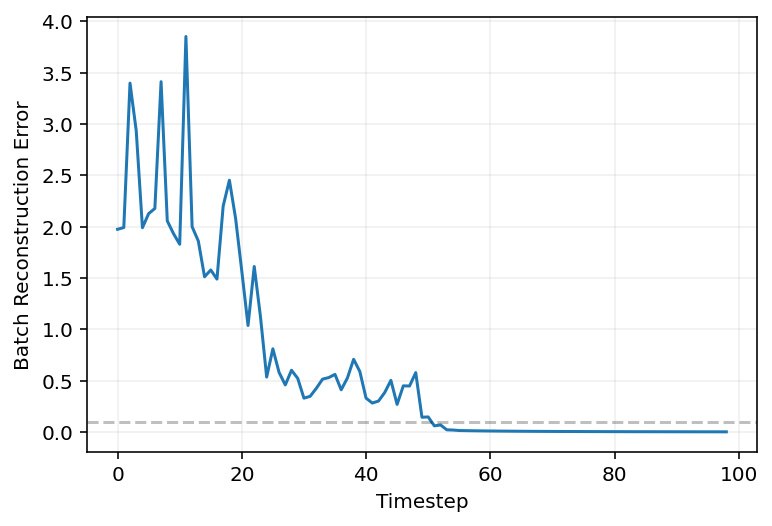

In [52]:
fig, ax = plt.subplots()
ax.plot(Error)
ax.set_xlabel('Timestep')
ax.set_ylabel('Batch Reconstruction Error')
ax.grid(True, alpha=0.2)
ax.axhline(y=0.1, ls='--', color='k', alpha=0.25)

# Plot the evolution of the reconstructed input

Here I draw the reconstructed batch of vectors. Step 0 shows the input batch. We see that it takes over 25 weight updates for the reconstructed image to strongly resemble in the input image. Note that we are using a zero regression ($\lambda = 0$) when saving the final reconstructed image during training, as Hinton & McClelland do in their paper.

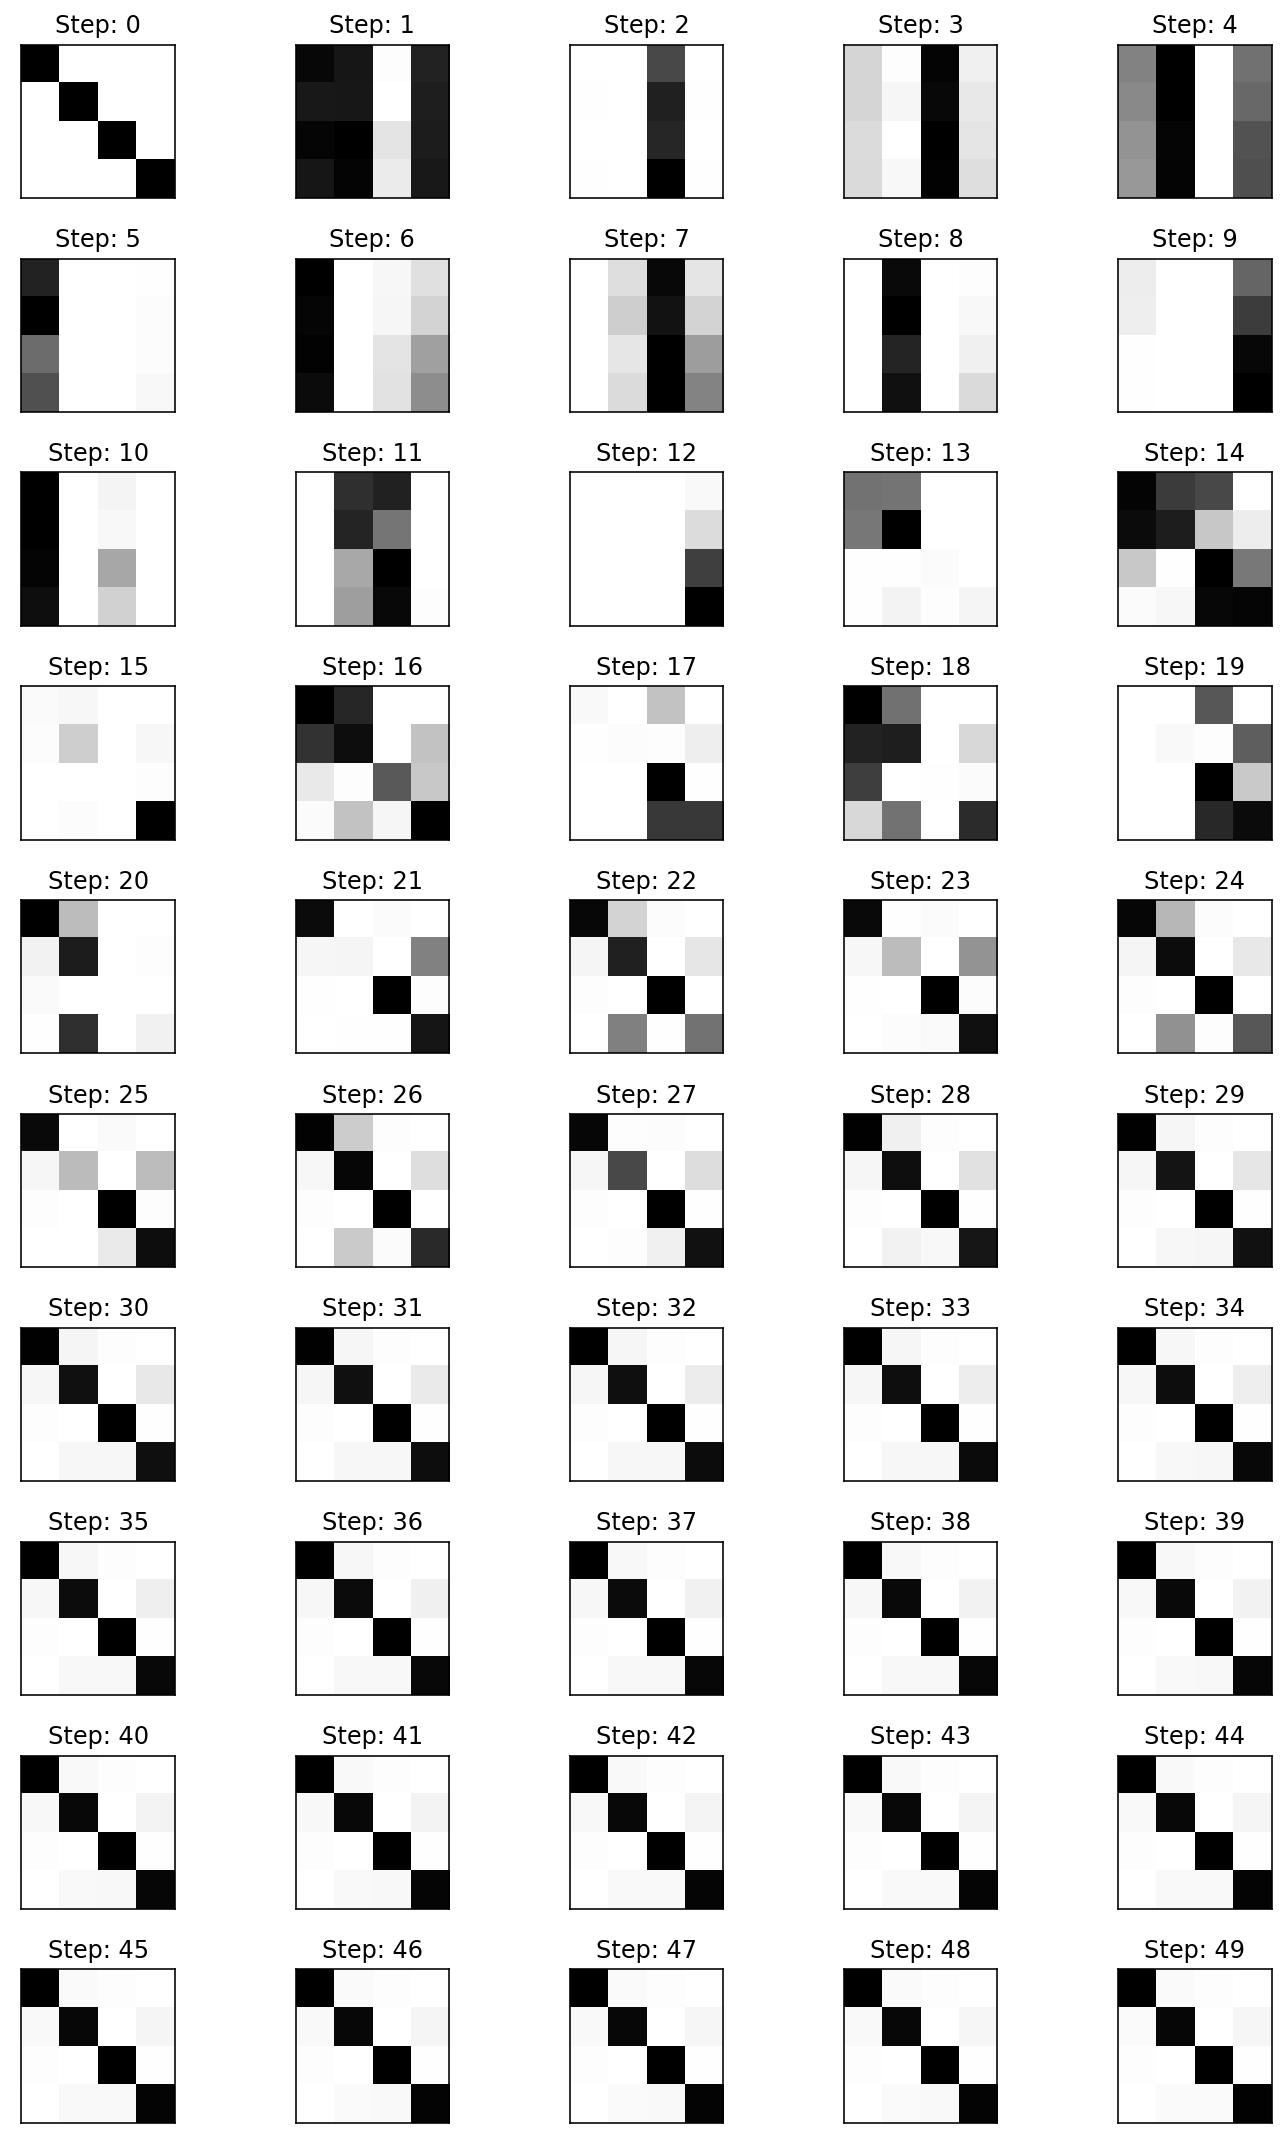

In [43]:
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(10,15))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(A[i], cmap='gray_r')
    ax.set_title('Step: {}'.format(i))
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()